In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving salon.png to salon.png
User uploaded file "salon.png" with length 138729 bytes


In [ ]:
import numpy as np
import cv2

def processImage(image):
    image = cv2.imread(image)
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
    return image

# https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

In [ ]:
image = processImage('salon.png')

In [ ]:
image.shape

(375, 660)

In [ ]:
filtre = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

In [ ]:
output = convolve2D(image, filtre, padding=2)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0. 180. ... 113.   0.   0.]
 ...
 [  0.   0. 119. ... 105.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [ ]:
cv2.imwrite('salon_horizontal.png', output)

True

In [ ]:
filtre = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

In [ ]:
output = convolve2D(image, filtre, padding=2)
cv2.imwrite('salon_vertical.png', output)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0. 180. ... 113.   0.   0.]
 ...
 [  0.   0. 119. ... 105.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


True

Test CNN sur les données de Fashion Mnist

In [ ]:
import tensorflow as tf
data = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = data.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
training_images = training_images / 255.0
test_images = test_images / 255.0

In [ ]:
training_labels = tf.keras.utils.to_categorical(training_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [ ]:
training_images.shape

(60000, 28, 28)

In [ ]:
training_images = training_images.reshape((60000,28,28,1))

In [ ]:
training_images.shape

(60000, 28, 28, 1)

In [ ]:
test_images = test_images.reshape((10000,28,28,1))

In [ ]:
test_images.shape

(10000, 28, 28, 1)

## Modeling

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [ ]:
model = Sequential([

    #Extraction de caractéristiques
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(28, 28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    # applatir
    tf.keras.layers.Flatten(),

    # Dense
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax"),
                ])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
6*6*64

2304

In [ ]:
10*64

640

In [ ]:
64*(64*9) +64

36928

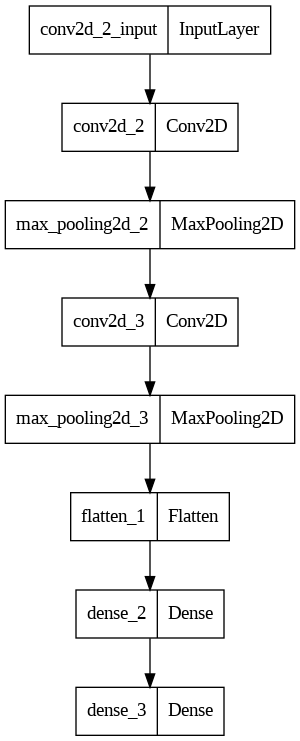

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
h= model.fit(training_images, training_labels, epochs=50,
             validation_data=(test_images, test_labels),
             callbacks = [model_ckp, stop])

Epoch 1/50
1875/1875 [==============================] - 79s 42ms/step - loss: 0.4031 - accuracy: 0.8541 - val_loss: 0.3027 - val_accuracy: 0.8884
Epoch 2/50
1875/1875 [==============================] - 76s 41ms/step - loss: 0.2620 - accuracy: 0.9036 - val_loss: 0.2610 - val_accuracy: 0.9059
Epoch 3/50
1875/1875 [==============================] - 76s 41ms/step - loss: 0.2168 - accuracy: 0.9203 - val_loss: 0.2509 - val_accuracy: 0.9105
Epoch 4/50
1875/1875 [==============================] - 74s 40ms/step - loss: 0.1843 - accuracy: 0.9309 - val_loss: 0.2286 - val_accuracy: 0.9194
Epoch 5/50
1875/1875 [==============================] - 74s 39ms/step - loss: 0.1578 - accuracy: 0.9408 - val_loss: 0.2503 - val_accuracy: 0.9125
Epoch 6/50
1875/1875 [==============================] - 77s 41ms/step - loss: 0.1354 - accuracy: 0.9493 - val_loss: 0.2385 - val_accuracy: 0.9192
Epoch 7/50
1875/1875 [==============================] - 74s 40ms/step - loss: 0.1160 - accuracy: 0.9559 - val_loss: 0.2503 -

In [ ]:
 MSE : loss: 0.0704 - accuracy: 0.5393 - val_loss: 0.0682 - val_accuracy: 0.5872

 CROSS ENTROPY : loss: 0.5450 - accuracy: 0.8112 - val_loss: 0.5563 - val_accuracy: 0.8020

 Relu : loss: 0.4099 - accuracy: 0.8585 - val_loss: 0.4308 - val_accuracy: 0.8479

 (20 epochs) : loss: 0.3009 - accuracy: 0.8936 - val_loss: 0.3549 - val_accuracy: 0.8744

 model complexe : loss: 0.2473 - accuracy: 0.9109 - val_loss: 0.3229 - val_accuracy: 0.8847

 Dropout : loss: 0.3238 - accuracy: 0.8834 - val_loss: 0.3361 - val_accuracy: 0.8800

 Adam : loss: 0.8879 - accuracy: 0.6822 - val_loss: 0.6868 - val_accuracy: 0.7686

 Callbacks : loss: 0.3065 - accuracy: 0.8892 - val_loss: 0.3300 - val_accuracy: 0.8801

 CNN : loss: 0.1843 - accuracy: 0.9309 - val_loss: 0.2286 - val_accuracy: 0.9194

# Projet : Classification d'objets Recyclables ou Non

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!ls '/gdrive'

MyDrive


In [ ]:
fichier_archive = 'gdrive/MyDrive/deep_learning_course/data/archive.zip'

In [ ]:
!unzip '/gdrive/MyDrive/deep_learning_course/data/archive.zip'

In [5]:
import os

In [6]:
data_dir = "DATASET"

In [7]:
train_dir = os.path.join(data_dir, "TRAIN")
test_dir = os.path.join(data_dir, "TEST")

In [8]:
os.listdir(train_dir)

['O', 'R']

In [9]:
train_r_dir = os.path.join(train_dir, "R")
train_o_dir = os.path.join(train_dir, "O")

In [10]:
len(os.listdir(train_r_dir))

9999

In [11]:
len(os.listdir(train_o_dir))

12565

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [13]:
r_index = 5680
o_index = 1496

recyclable_imgs = [os.path.join(train_r_dir, filename) for filename in os.listdir(train_r_dir)]
organic_imgs = [os.path.join(train_o_dir, filename) for filename in os.listdir(train_o_dir)]

img_r = mpimg.imread(recyclable_imgs[r_index])
img_o = mpimg.imread(organic_imgs[o_index])

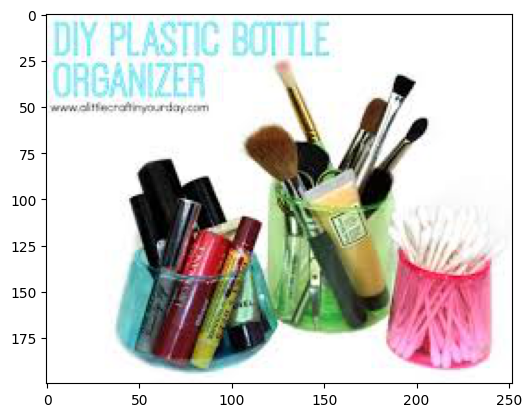

In [ ]:
plt.imshow(img_r)

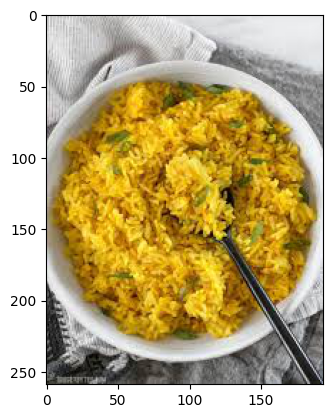

In [ ]:
plt.imshow(img_o)

In [ ]:
training_labels.shape

(60000, 10)

## ImageDataGenerator

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
train_data_generator = ImageDataGenerator(rescale=1/255.0)

test_data_generator = ImageDataGenerator(rescale=1/255.0)

In [16]:
train_generator = train_data_generator.flow_from_directory(
    directory = train_dir,
    target_size = (224, 224),
    batch_size=32,
    class_mode="binary"

)


test_generator = test_data_generator.flow_from_directory(
    directory = test_dir,
    target_size = (224, 224),
    batch_size=32,
    class_mode="binary"

)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
batch_images, batch_labels = next(iter(train_generator))

In [ ]:
batch_images.shape

(32, 224, 224, 3)

In [ ]:
batch_labels.shape

(32,)

In [ ]:
batch_labels

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [ ]:
train_generator.class_indices

{'O': 0, 'R': 1}

In [ ]:
batch_images[2].shape


(224, 224, 3)

## Modeling

In [17]:
import tensorflow as tf

In [18]:
model = tf.keras.models.Sequential([

    #Extraction de caractéristiques
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(224, 224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    # applatir
    tf.keras.layers.Flatten(),

    # Dense
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
                ])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [20]:
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)

In [21]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [22]:
h = model.fit(train_generator, epochs=50,
             validation_data=test_generator,
             callbacks = [model_ckp, stop])

Epoch 1/50
706/706 [==============================] - 66s 74ms/step - loss: 0.4767 - accuracy: 0.7912 - val_loss: 0.3718 - val_accuracy: 0.8520
Epoch 2/50
706/706 [==============================] - 53s 75ms/step - loss: 0.3867 - accuracy: 0.8375 - val_loss: 0.3218 - val_accuracy: 0.8818
Epoch 3/50
706/706 [==============================] - 52s 74ms/step - loss: 0.3468 - accuracy: 0.8558 - val_loss: 0.3069 - val_accuracy: 0.8854
Epoch 4/50
706/706 [==============================] - 53s 74ms/step - loss: 0.3180 - accuracy: 0.8714 - val_loss: 0.3131 - val_accuracy: 0.8834
Epoch 5/50
706/706 [==============================] - 52s 73ms/step - loss: 0.2942 - accuracy: 0.8854 - val_loss: 0.2266 - val_accuracy: 0.9180
Epoch 6/50
706/706 [==============================] - 51s 73ms/step - loss: 0.2632 - accuracy: 0.8984 - val_loss: 0.3213 - val_accuracy: 0.8894
Epoch 7/50
706/706 [==============================] - 49s 70ms/step - loss: 0.2308 - accuracy: 0.9119 - val_loss: 0.3544 - val_accuracy:

# Data Augmentation

In [23]:
# avant augmentation
train_data_generator = ImageDataGenerator(rescale=1/255.0)
test_data_generator = ImageDataGenerator(rescale=1/255.0)


# après augmentation
train_data_generator = ImageDataGenerator(rescale=1/255.0,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode="nearest")
test_data_generator = ImageDataGenerator(rescale=1/255.0)

In [24]:
train_generator = train_data_generator.flow_from_directory(
    directory = train_dir,
    target_size = (224, 224),
    batch_size=32,
    class_mode="binary"

)


test_generator = test_data_generator.flow_from_directory(
    directory = test_dir,
    target_size = (224, 224),
    batch_size=32,
    class_mode="binary"

)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [25]:
model = tf.keras.models.Sequential([

    #Extraction de caractéristiques
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(224, 224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    # applatir
    tf.keras.layers.Flatten(),

    # Dense
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
                ])

In [26]:
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="aug_model.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [28]:
h = model.fit(train_generator, epochs=50,
             validation_data=test_generator,
             callbacks = [model_ckp, stop])

Epoch 1/50
706/706 [==============================] - 263s 373ms/step - loss: 0.4269 - accuracy: 0.8164 - val_loss: 0.3179 - val_accuracy: 0.8774
Epoch 2/50
706/706 [==============================] - 265s 375ms/step - loss: 0.3886 - accuracy: 0.8329 - val_loss: 0.3001 - val_accuracy: 0.8890
Epoch 3/50
706/706 [==============================] - 260s 368ms/step - loss: 0.3743 - accuracy: 0.8418 - val_loss: 0.3901 - val_accuracy: 0.8384
Epoch 4/50
706/706 [==============================] - 257s 364ms/step - loss: 0.3635 - accuracy: 0.8466 - val_loss: 0.3209 - val_accuracy: 0.8774
Epoch 5/50
706/706 [==============================] - 255s 361ms/step - loss: 0.3518 - accuracy: 0.8522 - val_loss: 0.2764 - val_accuracy: 0.8957
Epoch 6/50
706/706 [==============================] - 254s 359ms/step - loss: 0.3421 - accuracy: 0.8586 - val_loss: 0.2785 - val_accuracy: 0.8854
Epoch 7/50
706/706 [==============================] - 256s 362ms/step - loss: 0.3388 - accuracy: 0.8649 - val_loss: 0.2869 -

In [ ]:
loss: 0.2942 - accuracy: 0.8854 - val_loss: 0.2266 - val_accuracy: 0.9180
loss: 0.3518 - accuracy: 0.8522 - val_loss: 0.2764 - val_accuracy: 0.8957

# Transfert Learning


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 128)     

## Extraction de caractéristiques

In [30]:
from tensorflow.keras.applications import vgg16

In [31]:
pretrained_model = vgg16.VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

553467096/553467096 [==============================] - 3s 0us/step


In [32]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [33]:
pretrained_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [34]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
(32, 224, 224, 3) ==> (32, 7, 7, 512)

### API Sequential

In [ ]:
model = tf.keras.models.Sequential([

    #Extraction de caractéristiques
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(224, 224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    # applatir
    tf.keras.layers.Flatten(),

    # Dense
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
                ])

In [35]:
model = tf.keras.models.Sequential()

In [36]:
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(224, 224,3)))

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.add(tf.keras.layers.MaxPooling2D(2,2))

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


### Api functional

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x =  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3))(inputs)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
outputs = tf.keras.layers.Flatten()(x)

In [ ]:
model = tf.keras.Model(inputs, outputs)

### Utilisation des filtres de VGG 16

In [40]:
pretrained_model.trainable = False

In [49]:
flatten_layer = tf.keras.layers.Flatten()


In [54]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = pretrained_model(inputs, training=False)
x = flatten_layer(x) # 7*7*512
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.Model(inputs, outputs)


In [55]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_19 (Dense)            (None, 128)               3211392   
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________


In [56]:
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="aug_model.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [57]:
h = model.fit(train_generator, epochs=50,
             validation_data=test_generator,
             callbacks = [model_ckp, stop])

Epoch 1/50
706/706 [==============================] - 295s 409ms/step - loss: 0.4094 - accuracy: 0.8459 - val_loss: 0.4192 - val_accuracy: 0.8253
Epoch 2/50
706/706 [==============================] - 291s 412ms/step - loss: 0.2943 - accuracy: 0.8797 - val_loss: 0.3822 - val_accuracy: 0.8544
Epoch 3/50
706/706 [==============================] - 293s 414ms/step - loss: 0.2751 - accuracy: 0.8923 - val_loss: 0.5225 - val_accuracy: 0.7883
Epoch 4/50
706/706 [==============================] - 293s 414ms/step - loss: 0.2640 - accuracy: 0.8917 - val_loss: 0.3377 - val_accuracy: 0.8719
Epoch 5/50
706/706 [==============================] - 292s 413ms/step - loss: 0.2535 - accuracy: 0.8995 - val_loss: 0.3664 - val_accuracy: 0.8563
Epoch 6/50
706/706 [==============================] - 291s 413ms/step - loss: 0.2455 - accuracy: 0.9023 - val_loss: 0.3682 - val_accuracy: 0.8591
Epoch 7/50
706/706 [==============================] - 292s 413ms/step - loss: 0.2405 - accuracy: 0.9029 - val_loss: 0.4243 -

In [ ]:
loss: 0.2942 - accuracy: 0.8854 - val_loss: 0.2266 - val_accuracy: 0.9180
loss: 0.3518 - accuracy: 0.8522 - val_loss: 0.2764 - val_accuracy: 0.8957
loss: 0.2165 - accuracy: 0.9160 - val_loss: 0.3172 - val_accuracy: 0.8926


## Fine Tuning

In [78]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [79]:
pretrained_model.layers

In [80]:
pretrained_model.trainable=True

In [81]:
pretrained_model.layers[:-4]

In [82]:
for layer in pretrained_model.layers[:-4]:
  layer.trainable = False

In [83]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = pretrained_model(inputs, training=False)
x = flatten_layer(x) # 7*7*512
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.Model(inputs, outputs)

In [84]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_25 (Dense)            (None, 128)               3211392   
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 10,290,945
Non-trainable params: 7,635,264
_________________________________________________________________


In [85]:
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="aug_model.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [76]:
h = model.fit(train_generator, epochs=50,
             validation_data=test_generator,
             callbacks = [model_ckp, stop])

Epoch 1/50
706/706 [==============================] - 277s 388ms/step - loss: 0.7018 - accuracy: 0.5565 - val_loss: 0.6866 - val_accuracy: 0.5575
Epoch 2/50
706/706 [==============================] - 276s 390ms/step - loss: 0.6867 - accuracy: 0.5569 - val_loss: 0.6866 - val_accuracy: 0.5575
Epoch 3/50
706/706 [==============================] - 277s 392ms/step - loss: 0.6867 - accuracy: 0.5569 - val_loss: 0.6865 - val_accuracy: 0.5575
